# Motivation
After playing around with a couple of off-the-shelf OCR engines, I decided to try my hand at creating my own model. I want something that's lightweight and accurate.

In this notebook, I'm going to try my hand at training a convolutional neural network to detect Boggle letters. 

# Setup
The cells below will set up the rest of the notebook. 

I'll start by configuring the kernel: 

In [1]:
# Change the directory to the root of the repo 
%cd ..

# Enable the autoreload extension
%load_ext autoreload
%autoreload 2

d:\data\programming\boggle-vision


Now that the kernel is configured, I'm going to load in some modules.

In [18]:
# General import statements
import os
import pandas as pd
from pathlib import Path

# Pytorch-related import statements
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

# Importing custom modules from this repo
from utils.settings import allowed_boggle_tiles

# Loading Data
I'm going to start by creating a custom `Dataset` for my network, and by specifying a `DataLoader`. Since it's been a bit, I'm going to follow [the Pytorch documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for this.

I'll start with the `Dataset`, which I'll call a `BoggleTileImageDataset`:

In [19]:
class BoggleTileImageDataset(Dataset):
    """
    This is a custom Dataset for handling the Boggle tile images.
    """

    def __init__(self, image_directory):
        """
        This is the initialization method. Here, I'll set some class variables
        for the image directory and the image paths.
        """

        # Set the img_dir class variable
        self.img_dir = image_directory
        
        # Create a mapping of letters to integers
        self.letter_to_int_dict = {letter: idx for idx, letter in enumerate(allowed_boggle_tiles)}

        # Create a class variable mapping each of the image paths to their labels
        self.img_path_to_label_dict = {}
        for child_file in Path(image_directory).iterdir():
            if child_file.suffix == ".png":
                cur_file_letter = child_file.name.split("_")[0]
                self.img_path_to_label_dict[child_file] = cur_file_letter

    def __len__(self):
        """
        This method will return the length of the dataset.
        """
        return len(self.img_path_to_label_dict)

    def __getitem__(self, idx):
        """
        This method will return the image and the label for a given index.
        """
        img_path = list(self.img_path_to_label_dict.keys())[idx]
        img = read_image(str(img_path))
        label = self.img_path_to_label_dict[img_path]
        label_int = self.letter_to_int_dict[label]
        label = torch.tensor(label_int)
        return img, label

With this custom `Dataset` in hand, I'm going to create an instance of it (as well as an accompanying `DataLoader`).  

In [20]:
training_data = BoggleTileImageDataset("data/training-data")
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)

**MISC:** Below, I can show one of the images from the training data, as well as its corresponding label:

Feature batch shape: torch.Size([64, 1, 100, 100])
Labels batch shape: torch.Size([64])


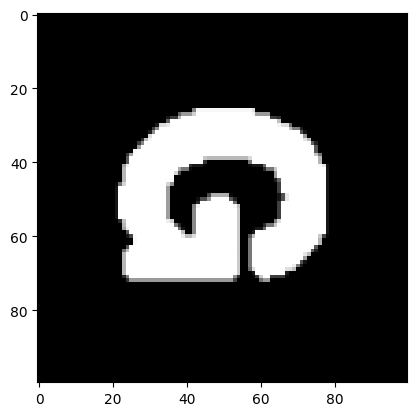

Label: 6 (G)


In [35]:
from matplotlib import pyplot as plt
train_features, train_labels = next(iter(training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label} ({allowed_boggle_tiles[label]})")